In [1]:
import torch
import torchvision
from matplotlib import pyplot as plt
from torchvision import datasets, transforms, models
from tqdm import tqdm
import time

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

transform_cnn = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

transform_vit = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])


cuda


In [3]:


trainset_vit = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_vit)

testset_vit = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_vit)

trainset_cnn = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_cnn)

testset_cnn = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_cnn)

trainloader_vit = torch.utils.data.DataLoader(
    trainset_vit, batch_size=128, shuffle=True)

testloader_vit = torch.utils.data.DataLoader(
    testset_vit, batch_size=128, shuffle=False)

trainloader_cnn = torch.utils.data.DataLoader(
    trainset_cnn, batch_size=128, shuffle=True)

testloader_cnn = torch.utils.data.DataLoader(
    testset_cnn, batch_size=128, shuffle=False)

In [4]:
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2,2)
        self.fc1 = nn.Linear(64*8*8, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)


In [5]:
from torchvision.models import vit_b_16

def get_vit_model(num_classes=10, freeze_backbone=True):

    model_vit = vit_b_16(weights="IMAGENET1K_V1")
    model_vit.heads.head = nn.Linear(
        model_vit.heads.head.in_features, num_classes)

    if freeze_backbone:
        for param in model_vit.parameters():
            param.requires_grad = False
        for param in model_vit.heads.head.parameters():
            param.requires_grad = True
    return model_vit

In [6]:
def train_one_epoch(model, loader, optimizer, criterion, device, epoch):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    pbar = tqdm(loader, desc=f"Epoch {epoch+1}", leave=False)
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        acc = 100 * correct / total

        pbar.set_postfix(
            loss=loss.item(),
            acc=f"{acc:.2f}%"
        )

    epoch_loss = running_loss / len(loader)
    epoch_acc = 100 * correct / total

    return epoch_loss, epoch_acc

In [7]:
def train_model(model, train_loader, test_loader, epochs, lr, name, device):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()

    if hasattr(model, "heads"):
        optimizer = torch.optim.Adam(model.heads.head.parameters(), lr=lr)
    else:
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    history = {"train_loss": [],
               "train_acc": [],
               "val_loss": [],
               "val_acc": [],
               "epoch_time": []
    }

    total_start_time = time.time()

    for epoch in range(epochs):
        epoch_start_time = time.time()

        train_loss, train_acc = train_one_epoch(
            model, train_loader, optimizer, criterion, device, epoch
        )
        val_loss, val_acc = evaluate(
            model, test_loader, criterion ,device
        )
        epoch_end = time.time()
        epoch_time = epoch_end - epoch_start_time
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)
        history["epoch_time"].append(epoch_time)

        print(
            f"Epoch {epoch+1}/{epochs} | "
            f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
            f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%"
            f"⏱ Time: {epoch_time:.1f}s"
        )
    total_time = time.time() - total_start_time
    print(f"✅ Total training time for {name}: {total_time/60:.2f} minutes")

    return history

In [8]:
def evaluate(model, loader, criterion, device, epoch=None, epochs=None):
    model.eval()
    running_loss = 0.0
    correct, total = 0, 0
    desc = "Validation" if epoch is None else f"Epoch {epoch+1}/{epochs} [Val]"
    val_bar = tqdm(loader, desc=desc, leave=False)
    with torch.no_grad():
        for images, labels in val_bar:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss = loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            val_bar.set_postfix(
                loss=loss.item(),
                accuracy= 100 * correct / total
            )
            val_loss = running_loss / len(loader)
            val_acc = 100 * correct / total

            return val_loss, val_acc

In [9]:
def plot_history(histories):
    # Loss
    plt.figure(figsize=(12,5))
    for name, history in histories.items():
        plt.plot(history["train_loss"], label=f"{name} Train Loss")
        plt.plot(history["val_loss"], linestyle="--", label=f"{name} Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Loss Curves")
    plt.show()

    # Accuracy
    plt.figure(figsize=(12,5))
    for name, history in histories.items():
        plt.plot(history["train_acc"], label=f"{name} Train Acc")
        plt.plot(history["val_acc"], linestyle="--", label=f"{name} Val Acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.legend()
    plt.title("Accuracy Curves")
    plt.show()


In [18]:
def plot_times_and_efficiency(histories):
    # --- Plot epoch times ---
    plt.figure(figsize=(12,5))
    for name, history in histories.items():
        plt.plot(history["epoch_time"], marker="o", label=name)
    plt.xlabel("Epoch")
    plt.ylabel("Seconds")
    plt.title("Training Time per Epoch")
    plt.legend()
    plt.grid(True)
    plt.show()

    # --- Compute efficiency ---
    names = []
    efficiencies = []

    for name, history in histories.items():
        total_time = sum(history["epoch_time"])
        final_acc = history["val_acc"][-1]
        sec_per_acc = total_time / final_acc

        names.append(name)
        efficiencies.append(sec_per_acc)

    # --- Bar plot efficiency ---
    plt.figure(figsize=(10,5))
    plt.bar(names, efficiencies)
    plt.ylabel("Seconds per 1% Accuracy")
    plt.title("Efficiency: Time Cost per Accuracy Unit")
    plt.xticks(rotation=30)
    plt.grid(True, axis="y")
    plt.show()

    # --- Print numeric table ---
    print("\n⏱ Efficiency Table:")
    for name, eff in zip(names, efficiencies):
        print(f"{name:15s} : {eff:.2f} seconds per 1% accuracy")


In [11]:

results = {}

# 1) CNN, 3 epochs, lr=1e-3
cnn_model = SimpleCNN()
history_cnn = train_model(cnn_model, trainloader_cnn, testloader_cnn,
                          epochs=3, lr=1e-3, name="CNN 3ep", device=device)
results["CNN 3ep"] = history_cnn

Epoch 1/3 | Train Loss: 1.3860, Train Acc: 50.16% | Val Loss: 0.0132, Val Acc: 66.41%⏱ Time: 21.2s


Epoch 2/3 | Train Loss: 1.0065, Train Acc: 64.48% | Val Loss: 0.0115, Val Acc: 69.53%⏱ Time: 18.1s


Epoch 3/3 | Train Loss: 0.8256, Train Acc: 71.05% | Val Loss: 0.0104, Val Acc: 67.19%⏱ Time: 17.9s
✅ Total training time for CNN 3ep: 0.95 minutes


In [12]:
# 2) CNN, 5 epochs, lr=1e-3
cnn_model = SimpleCNN()
history_cnn5 = train_model(cnn_model, trainloader_cnn, testloader_cnn,
                           epochs=5, lr=1e-3, name="CNN 5ep", device=device)
results["CNN 5ep"] = history_cnn5

Epoch 1/5 | Train Loss: 1.3987, Train Acc: 49.90% | Val Loss: 0.0127, Val Acc: 69.53%⏱ Time: 18.9s


Epoch 2/5 | Train Loss: 1.0130, Train Acc: 64.30% | Val Loss: 0.0110, Val Acc: 71.88%⏱ Time: 17.6s


Epoch 3/5 | Train Loss: 0.8503, Train Acc: 70.15% | Val Loss: 0.0093, Val Acc: 74.22%⏱ Time: 17.6s


Epoch 4/5 | Train Loss: 0.7288, Train Acc: 74.57% | Val Loss: 0.0103, Val Acc: 74.22%⏱ Time: 17.7s


Epoch 5/5 | Train Loss: 0.6277, Train Acc: 78.01% | Val Loss: 0.0088, Val Acc: 74.22%⏱ Time: 17.6s
✅ Total training time for CNN 5ep: 1.49 minutes


In [13]:
# 3) ViT, 3 epochs, lr=1e-3
vit_model = get_vit_model()
history_vit = train_model(vit_model, trainloader_vit, testloader_vit,
                          epochs=3, lr=1e-3, name="ViT 3ep", device=device)
results["ViT 3ep"] = history_vit

Epoch 1/3 | Train Loss: 0.3018, Train Acc: 91.46% | Val Loss: 0.0020, Val Acc: 94.53%⏱ Time: 1095.4s


Epoch 2/3 | Train Loss: 0.1754, Train Acc: 94.27% | Val Loss: 0.0018, Val Acc: 95.31%⏱ Time: 1074.7s


Epoch 3/3 | Train Loss: 0.1560, Train Acc: 94.89% | Val Loss: 0.0018, Val Acc: 95.31%⏱ Time: 1063.4s
✅ Total training time for ViT 3ep: 53.89 minutes


In [14]:
# 4) ViT, 5 epochs, lr=1e-3
vit_model = get_vit_model()
history_vit5 = train_model(vit_model, trainloader_vit, testloader_vit,
                           epochs=5, lr=1e-3, name="ViT 5ep", device=device)
results["ViT 5ep"] = history_vit5

Epoch 1/5 | Train Loss: 0.3054, Train Acc: 91.38% | Val Loss: 0.0024, Val Acc: 93.75%⏱ Time: 1062.9s


Epoch 2/5 | Train Loss: 0.1759, Train Acc: 94.25% | Val Loss: 0.0020, Val Acc: 94.53%⏱ Time: 1084.3s


Epoch 3/5 | Train Loss: 0.1561, Train Acc: 94.92% | Val Loss: 0.0019, Val Acc: 94.53%⏱ Time: 1077.1s


Epoch 4/5 | Train Loss: 0.1444, Train Acc: 95.21% | Val Loss: 0.0018, Val Acc: 94.53%⏱ Time: 1083.7s


Epoch 5/5 | Train Loss: 0.1363, Train Acc: 95.45% | Val Loss: 0.0018, Val Acc: 95.31%⏱ Time: 1083.9s
✅ Total training time for ViT 5ep: 89.86 minutes


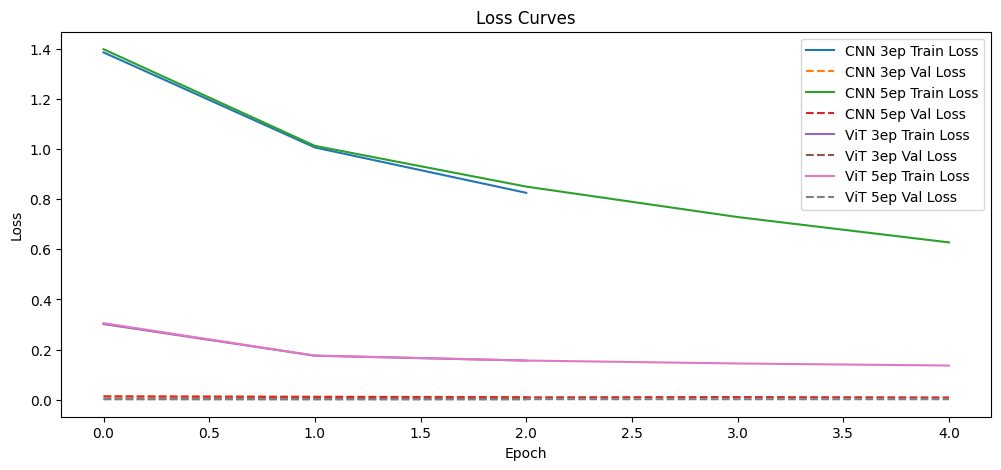

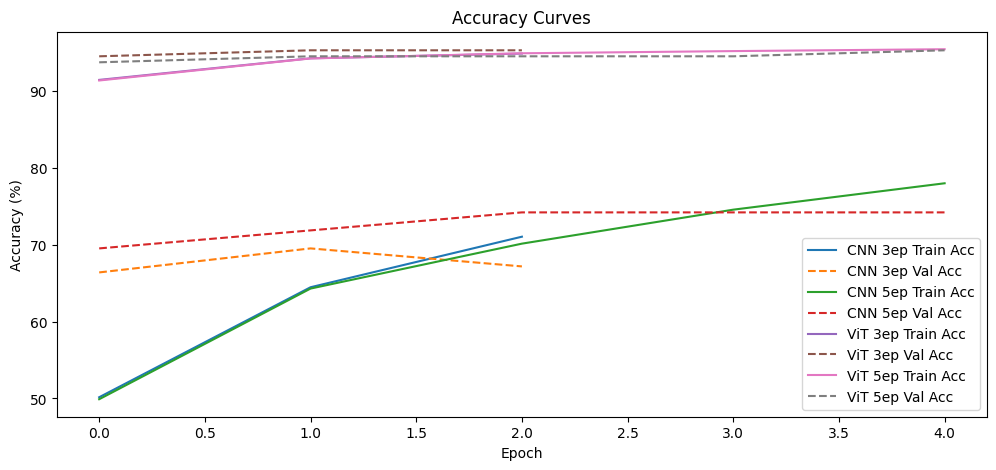

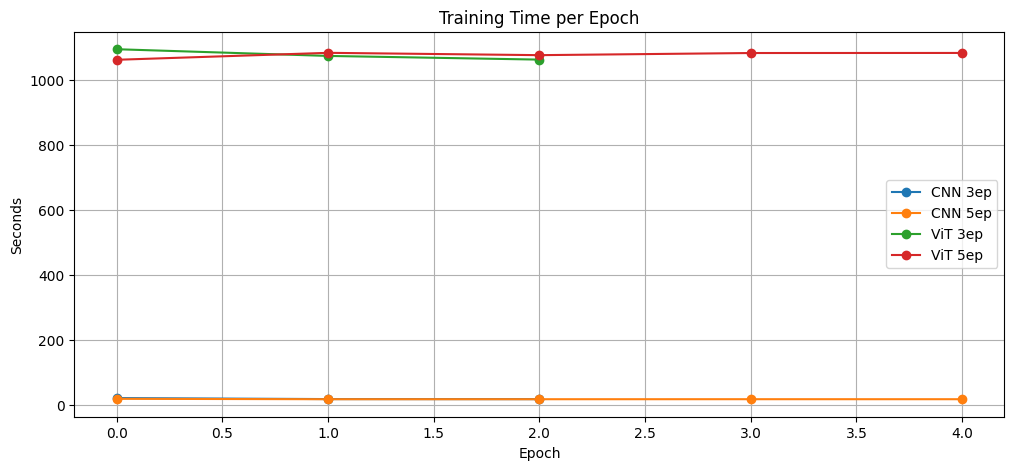

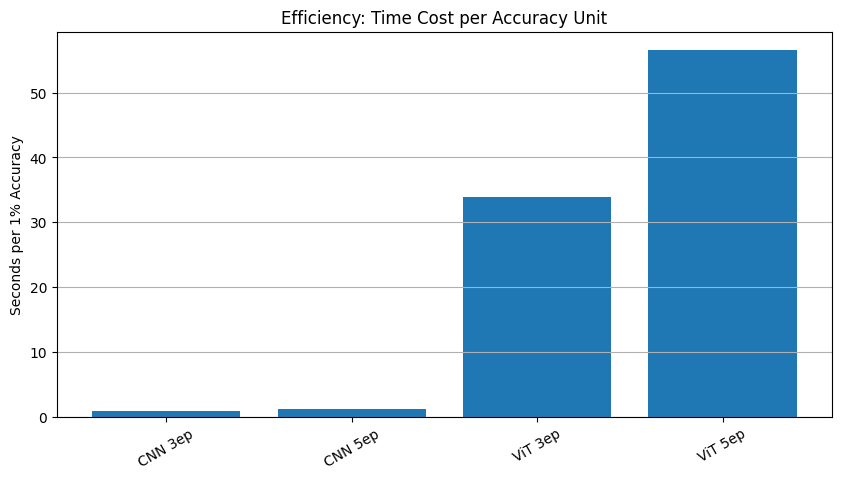


⏱ Efficiency Table:
CNN 3ep         : 0.85 seconds per 1% accuracy
CNN 5ep         : 1.20 seconds per 1% accuracy
ViT 3ep         : 33.93 seconds per 1% accuracy
ViT 5ep         : 56.57 seconds per 1% accuracy


In [19]:

plot_history(results)
plot_times_and_efficiency(results)